In [1]:
%matplotlib inline

# 1.Define an Area Of Interest

For example, you can get the coordinates of a box around a point with the following code:

In [2]:
from osmnx import bbox_from_point
lat=-1.290593
lon=36.8918607
dist = 2000
north, south, east, west = bbox_from_point(point=(lat,lon), distance=dist)

In [3]:
from shapely.geometry import Polygon
from shapely.geometry import mapping
point1=(east,south)
point2=(west,south)
point3=(west,north)
point4=(east,north)
AOI = Polygon([point1,point2,point3,point4])
AOI_geojson = mapping(AOI)

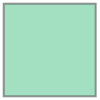

In [4]:
AOI

Plot the AOI on Open Stree Map API

Lowered zoom level to keep map size reasonable. (z = 14)


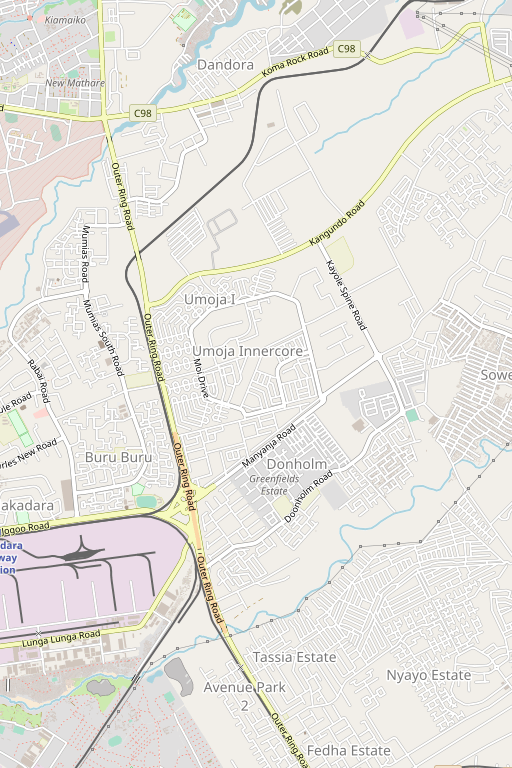

In [5]:
import smopy
map = smopy.Map((south, west, north, east), tileserver="https://a.tile.openstreetmap.org/${z}/${x}/${y}.png ")
map.show_ipython()

# 2. Get OSM data within your AOI

https://overpass-turbo.eu/ helps you to create OSM queries. 

For example to get all the schools (polygons and point) within the AOI, the query is as follow:

In [6]:
query_schools = ('[out:json][timeout:25];'
                   '('
                   'node["amenity"="school"]({south:.8f},{west:.8f},{north:.8f},{east:.8f});'
                   'way["amenity"="school"]({south:.8f},{west:.8f},{north:.8f},{east:.8f});'
                   'relation["amenity"="school"]({south:.8f},{west:.8f},{north:.8f},{east:.8f});'
                   ');(._;>;);out;')

To get all the residential areas:

In [7]:
query_residentials = ('[out:json][timeout:25];'
                      '(way["landuse"="residential"]({south:.8f},{west:.8f},{north:.8f},{east:.8f});'
                      'relation["landuse"="residential"]({south:.8f},{west:.8f},{north:.8f},{east:.8f});'
                      ');(._;>;);out;')

In [8]:
query_str = query_schools.format(north=north, south=south, east=east, west=west)

In [9]:
from osmnx.core import overpass_request
response_json = overpass_request(data={'data':query_str}, timeout=600, error_pause_duration=None)

# 3. Load the response JSON into a GeoDataFrame

The difficulty is to get both the polygons and the points into the geodataframe. 
Polygons are defined by their node ID in the response json. The response JSON also includes the coordinates of each nodes. 
The nodes ID that are in the repsponse json but not in the polygons are the point objects.

In [10]:
from shapely.geometry import Point

vertices = {}
vertices_set=set()
for result in response_json['elements']:
    if 'type' in result and result['type']=='node':
        vertices[result['id']] = {'lat' : result['lat'],
                                  'lon' : result['lon']}
        vertices_set.add(result['id'])

buildings = {}
buildings_set=set()
for result in response_json['elements']:
    if 'type' in result and result['type']=='way':
        nodes = result['nodes']
        buildings_set.update(nodes)
        try:
            polygon = Polygon([(vertices[node]['lon'], vertices[node]['lat']) for node in nodes])
        except Exception:
            log('Polygon has invalid geometry: {}'.format(nodes))
        building = {'geometry' : polygon}

        buildings[result['id']] = building
            
points_set = vertices_set - buildings_set

points={}
for node in points_set:
    p = Point([(vertices[node]['lon'], vertices[node]['lat'])])
    point = {'geometry' : p}
    points[node] = point

In [11]:
import geopandas as gpd
gdf = gpd.GeoDataFrame({**buildings,**points}).T
gdf.crs = {'init':'epsg:4326'}

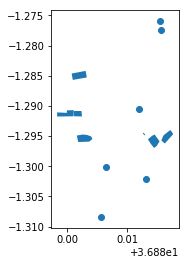

In [12]:
gdf.plot()

In [13]:
gdf.head()

,geometry
164581835,"POLYGON ((36.895641 -1.2957504, 36.8961602 -1...."
164582021,"POLYGON ((36.8944183 -1.2969731, 36.8948582 -1..."
164582082,"POLYGON ((36.8928248 -1.2948763, 36.8929639 -1..."
550105831,POINT (36.8956499 -1.2774597)
572001808,"POLYGON ((36.8816215 -1.2949361, 36.8818522 -1..."


# 4. Rasterize the GeoDataFrame

You might need a raster if you want for example to:
* Use the data as a training set for a classifier
* Do proximity analysis (ex: distance to closest school)

An input raster is necessary to "burn" the polygons. Depending on the size of your polygons, you might need a small cell size if you want to keep the general form. You can for example download country rasters here: http://countrytoraster.herokuapp.com/

In [14]:
input_raster = "/Users/pasquierjb/Downloads/KEN_0.001_4326_1.tif"
output_raster = "/Users/pasquierjb/Downloads/KEN_0.001_4326_1_schools.tif"

In [15]:
from rasterio import features
import rasterio.mask
from shapely.geometry import mapping

def rasterize(convert_to_rast, out_rast, meta, field, AOI):
    with rasterio.open("/tmp/temp.tif", 'w', **meta) as out:
        out_arr = out.read(1)
        shapes = ((geom,value) for geom, value in zip(convert_to_rast.geometry, convert_to_rast[field]))
        
        # Rasterize for each shape
        burned = features.rasterize(shapes=shapes, fill=1, out=out_arr, transform=out.transform, all_touched=True)
        out.write_band(1, burned)
        
        boundary_box=[AOI]
        
        # Crop the raster to your AOI
        out_image, out_transform = rasterio.mask.mask(out, boundary_box, crop=True)
        out_meta = out.meta.copy()
        
   
        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
            
    with rasterio.open(out_rast, 'w', **out_meta) as out:
        out.write(out_image)
        return out.read()
        

In [16]:
rst = rasterio.open(input_raster,crs=4326)
convert_to_rast = gdf[["geometry"]]
convert_to_rast['Junk'] = 1    
meta = rst.meta.copy()  
meta.update(crs={'init': 'EPSG:4326'})   
print(meta)
data=rasterize(convert_to_rast, output_raster, meta,  field='Junk', AOI=AOI_geojson)

{'crs': {'init': 'EPSG:4326'}, 'driver': 'GTiff', 'count': 1, 'nodata': 0.0, 'height': 10185, 'dtype': 'uint8', 'transform': Affine(0.001, 0.0, 33.9,
       0.0, -0.001, 5.492285156250006), 'width': 7984}


In [17]:
print("{} pixels burned out of {}".format(data.sum(), data.size))

47 pixels burned out of 1332


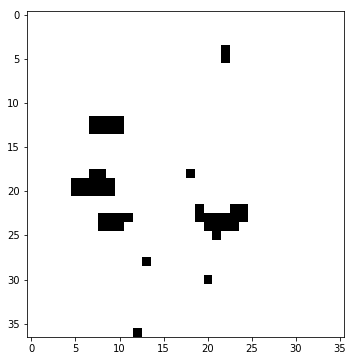

In [18]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6, 6))
ax = plt.imshow(data[0], cmap='gray_r')